# FunUQ for MD
## Sam Reeve and Alejandro Strachan

### Functional derivative calculation comparison

#### This notebook goes through all steps computing the functional derivative, for use in functional uncertainty quantification (FunUQ) for interatomic potentials in molecular dynamics. The three methods are: 
 * Bruteforce (run a new simulation with each perturbation)
 * Perturbative all-atom (calculate perturbation contribution separately with saved atomic coordinates (LAMMPS dump and rerun))
 * Perturbative RDF (calculate perturbation contribuation separately with saved RDF)
 
#### Each method needs different perturbation sizes, converges in different amounts of simulation time or number of samples, and takes different amounts of time to compute

In [1]:
import sys, os, numpy as np
# Relative path from notebook to module
sys.path.insert(0, '../../lib/')
sys.path.insert(0, '../../lib/FunUQ/')

In [2]:
# Import FunUQ module
from FunUQ import *

# Provides access to nanoHUB simulation codes (LAMMPS)
from hublib import use

# Utility functions (Austin Zadoks)
from nH_utils import *

In [3]:
% use lammps-09Dec14
% matplotlib notebook

In [37]:
# "True" will run new simulations below
# Change after first usage to only analyze results
RUN_main = True
RUN_perturb = True
RUN_bruteforce = True

## System setup: define interatomic potentials and quantities of interest

In [5]:
rundir = os.getcwd()
startdir = os.path.abspath(os.path.join(rundir, 'init/'))

mainname = 'main' # morse

In [6]:
Pot_main = Potential('morse', paramdir=startdir, create=True, N=7000, rmax=7.0, cut=6.0)

In [7]:
#ax1 = Pot_main.plot()

In [67]:
QoI_list = ['PotEng', 'Press']
Nqoi = len(QoI_list)
QoI_dict = {'description': 'Default.',
            'Ncopies': 2,
            'units': ['eV/atom', 'GPa'],
            #'overwrite': True, 
           }

In [68]:
QoI = QuantitiesOfInterest(QoI_list, Pot_main,
                           startdir, rundir, mainname, 'metal',
                           input_dict=QoI_dict)

## Run unperturbed simulations and extract results

In [10]:
if RUN_main:
    QoI.run_lammps(mode='nanoHUB_submit') # 'nanoHUB_local'

In [88]:
submit_status()
local_status(rundir, [mainname, 'bruteforce'])

In [12]:
#kill_jobs('06840071') # Use RunName from submit_status()
#kill_all_jobs()

In [13]:
#! ls $rundir

In [69]:
QoI.extract_lammps()
print(QoI)

PotEng	Press
-0.616	0.090	



## Calculate RDF perturbative functional derivatives (Fast: no additional simulation)

In [76]:
perturb_rdf_dict = {'alist': [-1e-6, -2e-6, 1e-6, 2e-6]}

In [77]:
FD_perturb_rdf = FuncDer_perturb_coord(QoI, Pot_main,
                                        input_dict=perturb_rdf_dict)

In [78]:
FD_perturb_rdf.prepare_FD()
FD_perturb_rdf.calc_FD()

Calculated perturbations
Extracted RDF data for copy 0
Extracted RDF data for copy 1
Calculated perturbation Hamiltonian contributions
Calculated exponential weights
Calculated functional derivatives



<IPython.core.display.Javascript object>


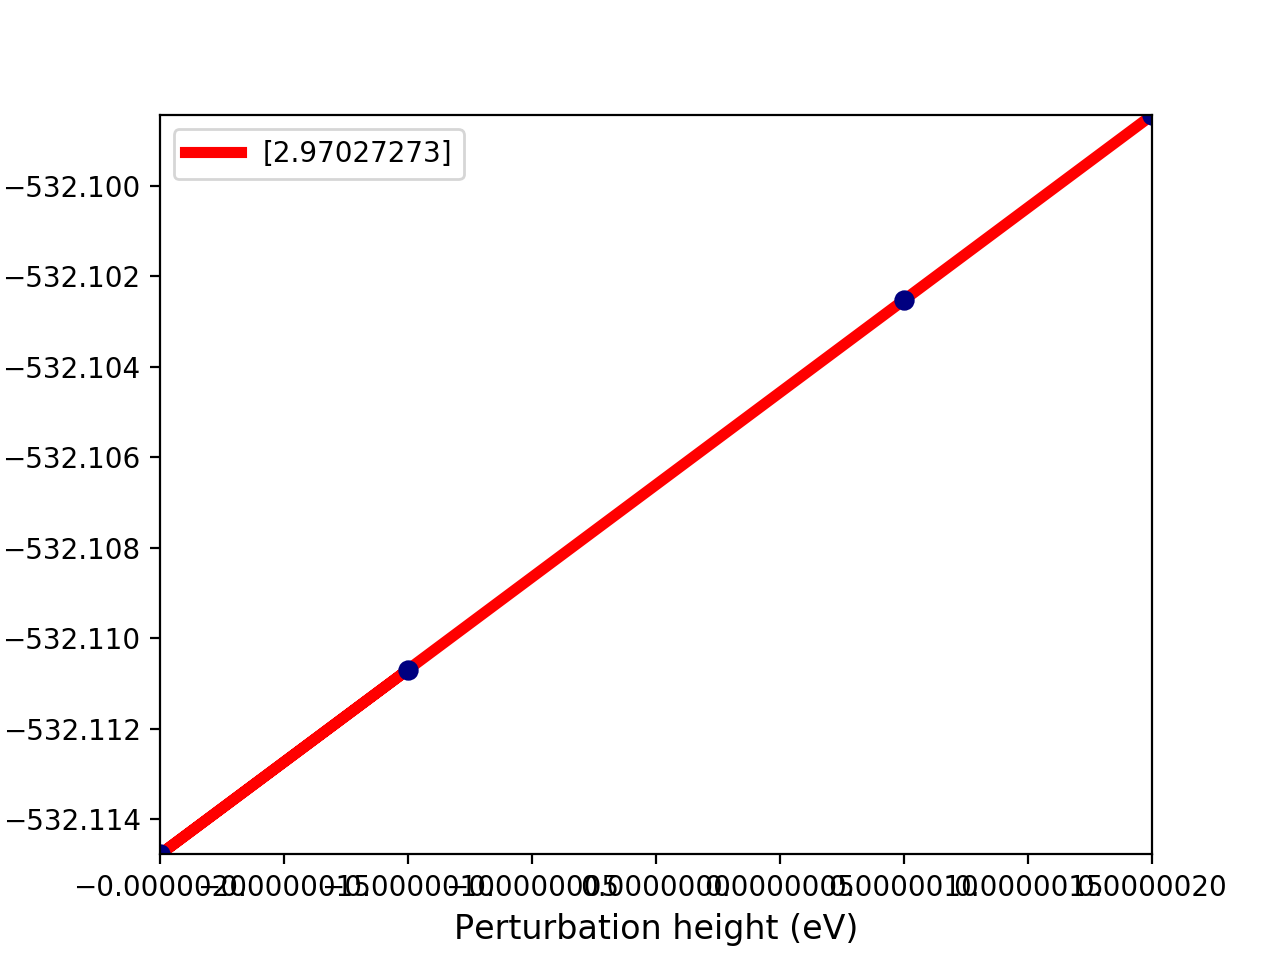

In [79]:
FD_perturb_rdf.plot_perturb(0, r0=3)

<IPython.core.display.Javascript object>


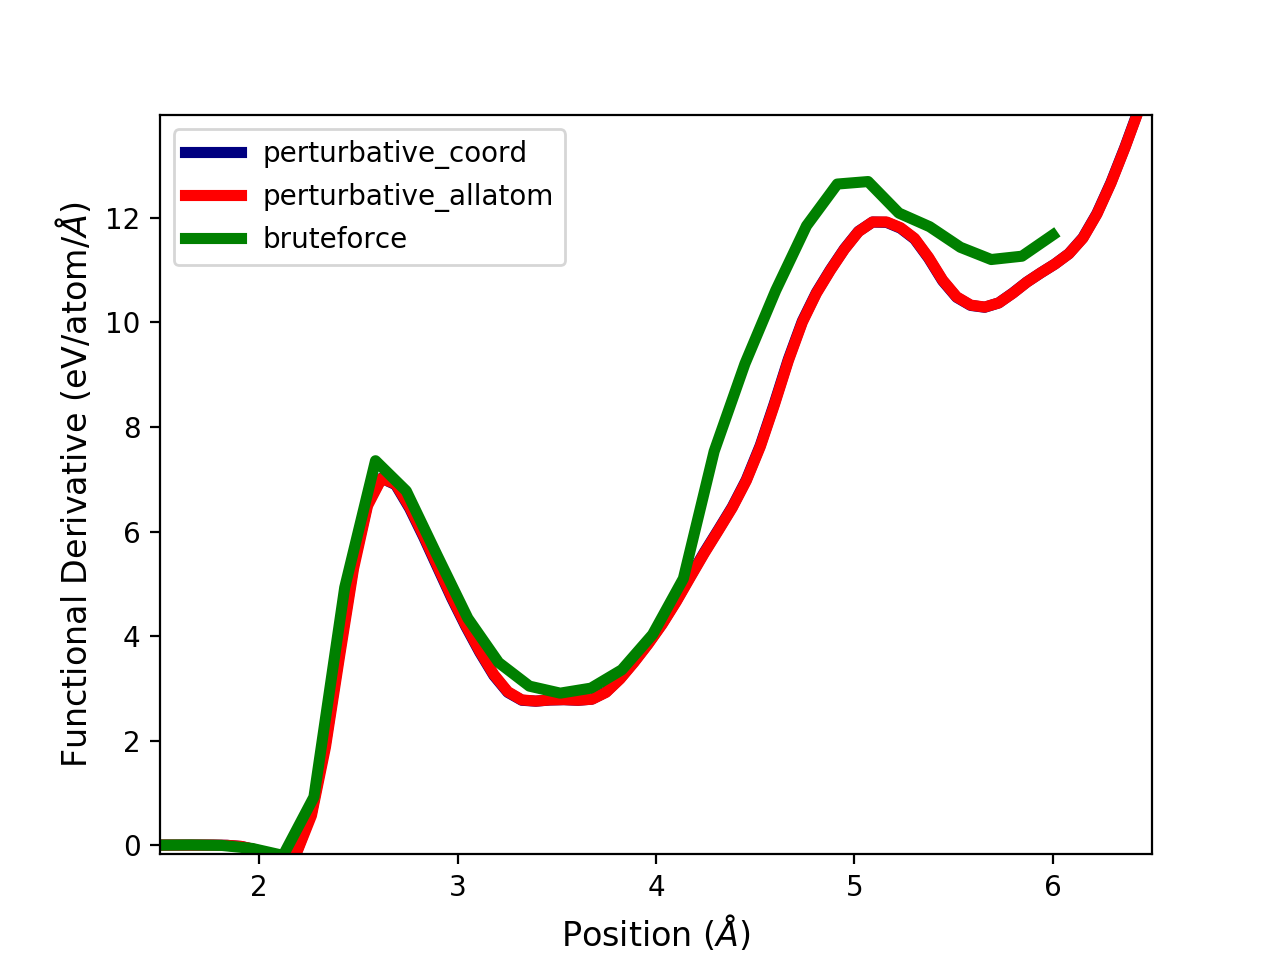

<IPython.core.display.Javascript object>


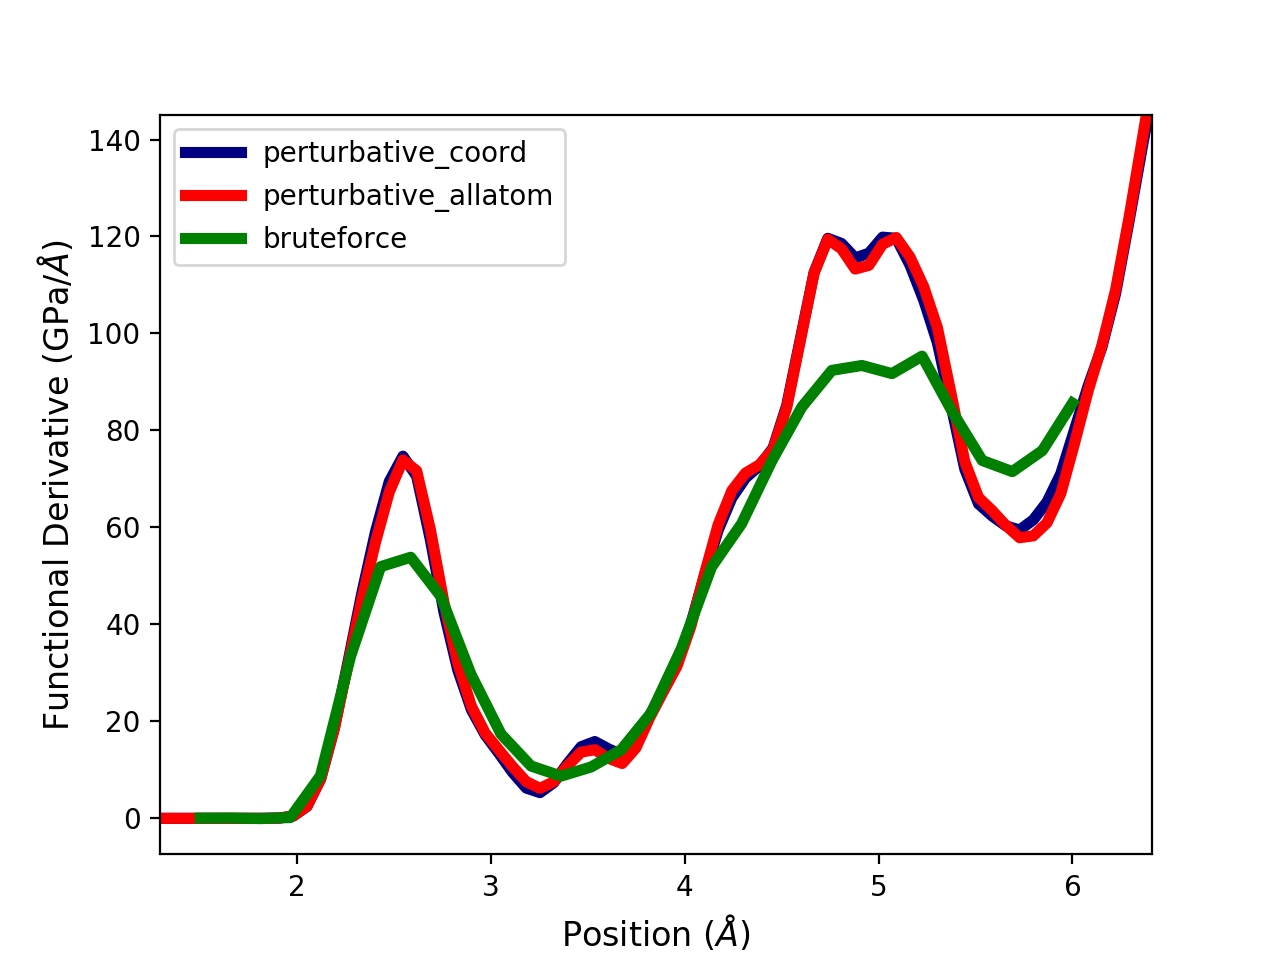

In [80]:
axFD = ['']*2
for x in range(Nqoi):
    FD_perturb_rdf.write_FD(x)
    axFD[x] = FD_perturb_rdf.plot_FD(x, color='navy')

## Calculate all-atom perturbative functional derivatives (Intermediate time to run)

In [81]:
perturb_allatom_dict = {'alist': [-1e-6, -2e-6, 1e-6, 2e-6], 
                        'Ncopies': 2,
                        }

In [82]:
FD_perturb_atom = FuncDer_perturb_allatom(QoI, Pot_main,
                                         input_dict=perturb_allatom_dict)

In [89]:
if RUN_perturb:
    FD_perturb_atom.rerun_gauss(mode='nanoHUB_local_wait') # Running too many at once ('nanoHUB_local') will hang

In [83]:
FD_perturb_atom.prepare_FD()
FD_perturb_atom.calc_FD()

Extracted thermodynamic data for perturbation position 0.001
Extracted thermodynamic data for perturbation position 0.07169696969696969
Extracted thermodynamic data for perturbation position 0.14239393939393938
Extracted thermodynamic data for perturbation position 0.21309090909090905
Extracted thermodynamic data for perturbation position 0.28378787878787876
Extracted thermodynamic data for perturbation position 0.35448484848484846
Extracted thermodynamic data for perturbation position 0.4251818181818181
Extracted thermodynamic data for perturbation position 0.4958787878787878
Extracted thermodynamic data for perturbation position 0.5665757575757575
Extracted thermodynamic data for perturbation position 0.6372727272727272
Extracted thermodynamic data for perturbation position 0.7079696969696969
Extracted thermodynamic data for perturbation position 0.7786666666666666
Extracted thermodynamic data for perturbation position 0.8493636363636362
Extracted thermodynamic data for perturbation 

<IPython.core.display.Javascript object>


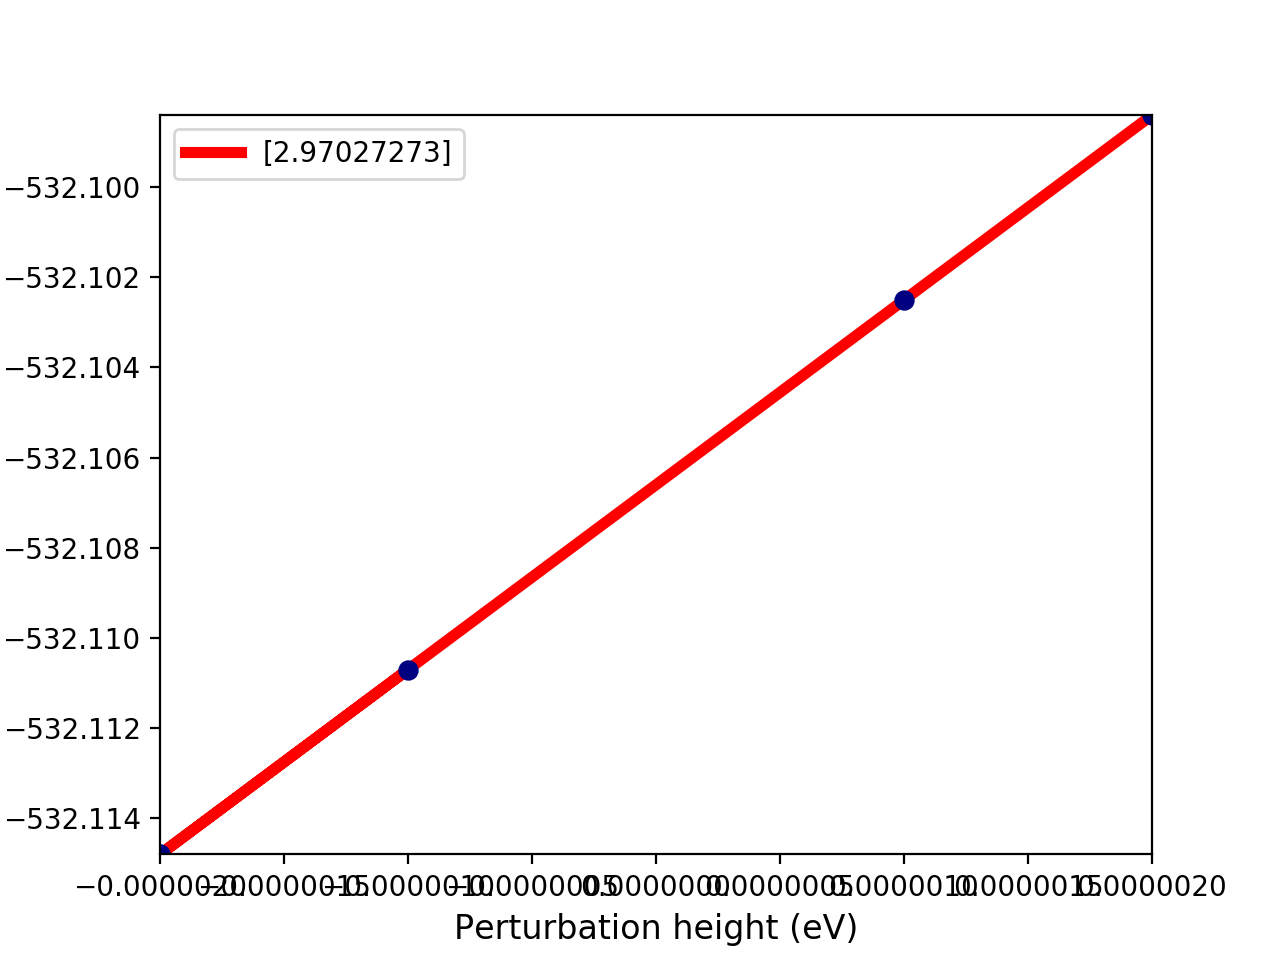

In [84]:
FD_perturb_atom.plot_perturb(0, r0=3)

### The next cell will plot together with the other FD above

In [85]:
# Plot together with the other FD above
for x in range(Nqoi):
    FD_perturb_atom.write_FD(x)
    axFD[x] = FD_perturb_atom.plot_FD(x, ax=axFD[x], color='red')

## Calculate bruteforce functional derivatives (Long run time)

In [46]:
brute_dict = {'alist': [-1e-2, -2e-2, 1e-2, 2e-2], 
             'rlist': np.linspace(1.5, 6., 30), #[16]],
              'rmin': 1.5,
              'Ncopies': 1,
              }

In [47]:
FD_brute = FuncDer_bruteforce(QoI, Pot_main,
                             input_dict=brute_dict)

In [48]:
if RUN_bruteforce:
    FD_brute.run_lammps(mode='nanoHUB_submit')
    
    # OR Check for failed jobs and rerun
    #FD_brute.resubmit_lammps(mode='nanoHUB_submit', strict=True)

In [49]:
#submit_status()

In [50]:
#kill_all_jobs()

In [51]:
FD_brute.prepare_FD()
FD_brute.calc_FD()

Extracted thermodynamic data for position 1.5
Extracted thermodynamic data for position 1.6551724137931034
Extracted thermodynamic data for position 1.8103448275862069
Extracted thermodynamic data for position 1.9655172413793105
Extracted thermodynamic data for position 2.1206896551724137
Extracted thermodynamic data for position 2.2758620689655173
Extracted thermodynamic data for position 2.431034482758621
Extracted thermodynamic data for position 2.586206896551724
Extracted thermodynamic data for position 2.7413793103448274
Extracted thermodynamic data for position 2.896551724137931
Extracted thermodynamic data for position 3.0517241379310347
Extracted thermodynamic data for position 3.206896551724138
Extracted thermodynamic data for position 3.3620689655172415
Extracted thermodynamic data for position 3.5172413793103448
Extracted thermodynamic data for position 3.6724137931034484
Extracted thermodynamic data for position 3.8275862068965516
Extracted thermodynamic data for position 3

<IPython.core.display.Javascript object>


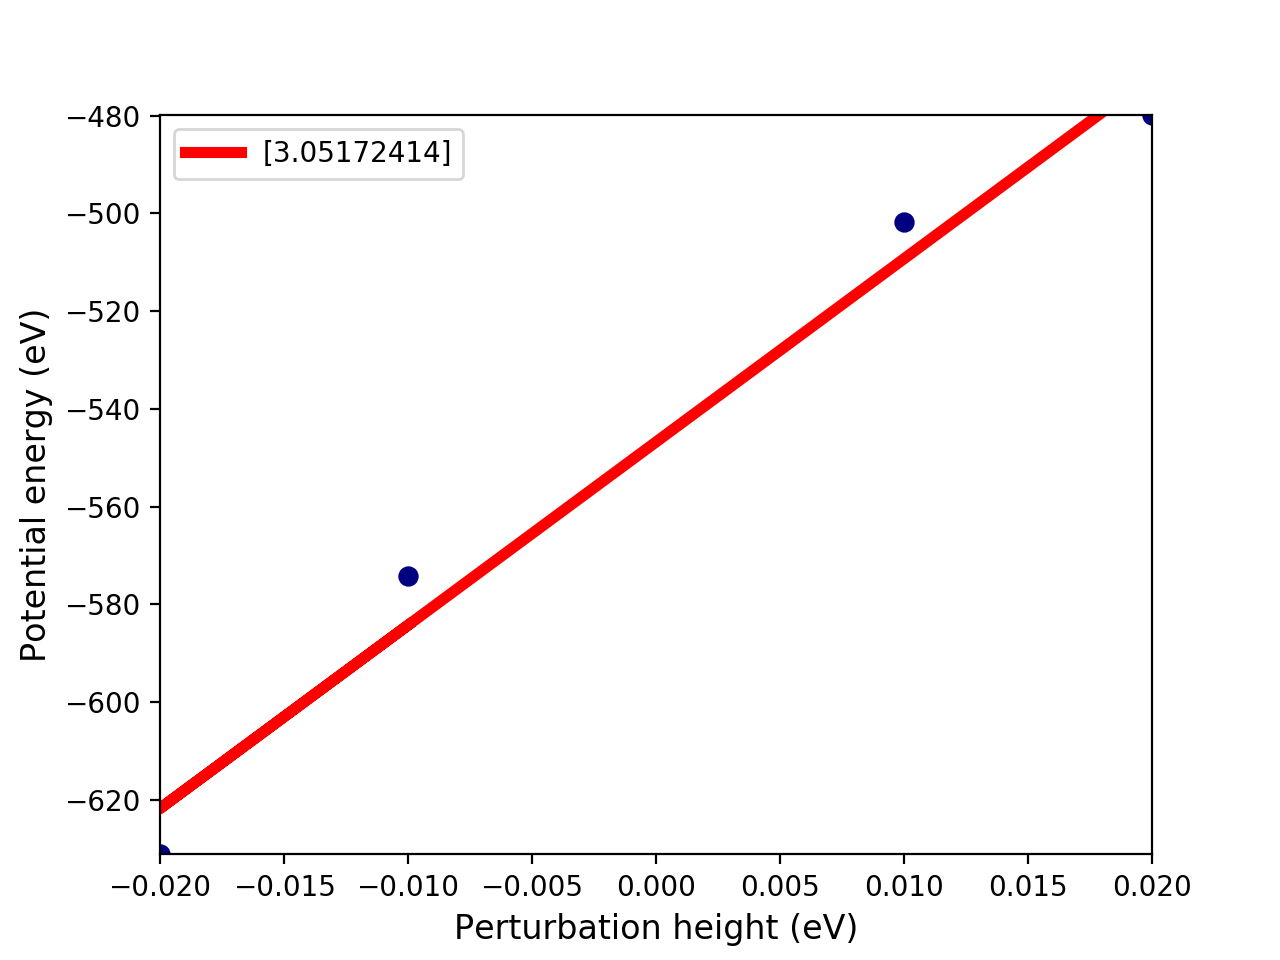

In [86]:
FD_brute.plot_perturb(0, r0=3)

### The next cell will plot together with the other FD above

In [87]:
for x in range(Nqoi):
    FD_brute.write_FD(x)
    axFD[x] = FD_brute.plot_FD(x, ax=axFD[x], color='green')

## A good test for the quality of the FD is correction from one function to another (see other example notebooks)